In [463]:
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
import numpy as np
# Read the wav file

music = 'boards_of_canada.wav'
sample_rate, data = wavfile.read(music)

sample_rate, data


(48000,
 array([[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]], dtype=int16))

In [464]:
# Normalize to mono
data = data.sum(axis=1) / 2

data

array([0., 0., 0., ..., 0., 0., 0.])

In [465]:
# Perform the Fourier transform
frequencies, times, Zxx = signal.stft(data, fs=sample_rate, nperseg=sample_rate//5, noverlap=sample_rate//10)
mask = (frequencies > 20) & (frequencies < 8000)
frequencies = frequencies[mask]
Zxx = Zxx[mask, :]

len(times)

1599

In [466]:
# Take absolute value to get magnitude (power)
Zxx = np.abs(Zxx)

Zxx

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [467]:
# Now you can perform your frequency binning on Zxx, just remember it needs to be done for each column (time step)
num_bins = 4

bin_edges = np.logspace(np.log10(min(frequencies)+1), np.log10(max(frequencies)), num_bins+1)
bin_medians = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]
bin_freqs = np.digitize(frequencies, bins=bin_edges)

bin_vols_over_time = []
for t in range(Zxx.shape[1]):
    bin_vols = [np.sum(Zxx[bin_freqs==i, t]) for i in range(1, num_bins+1)]
    bin_vols_over_time.append(bin_vols)

bin_vols_over_time = np.array(bin_vols_over_time)

In [468]:
bin_vols_over_time[280]

array([ 7238.30199539, 11839.2301616 , 21239.86239643, 51396.23269619])

In [469]:
# Normalize each time step separately
bin_vols_over_time = bin_vols_over_time / np.max(bin_vols_over_time, axis=1, keepdims=True)
# Scale to integer values for visualization
bin_vols_over_time = np.round(bin_vols_over_time * 4).astype(int)

/var/folders/7l/92mph18d5nj1f6l32ly6l4zr0000gn/T/ipykernel_44136/1673857288.py:2: RuntimeWarning: invalid value encountered in divide
  bin_vols_over_time = bin_vols_over_time / np.max(bin_vols_over_time, axis=1, keepdims=True)
/var/folders/7l/92mph18d5nj1f6l32ly6l4zr0000gn/T/ipykernel_44136/1673857288.py:4: RuntimeWarning: invalid value encountered in cast
  bin_vols_over_time = np.round(bin_vols_over_time * 4).astype(int)


In [470]:
import matplotlib.pyplot as plt
# Create a new figure



/var/folders/7l/92mph18d5nj1f6l32ly6l4zr0000gn/T/ipykernel_44136/2475998096.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(times, [20 * np.log10(vol_over_time[bin_index]) for vol_over_time in bin_vols_over_time], linewidth=0.5)


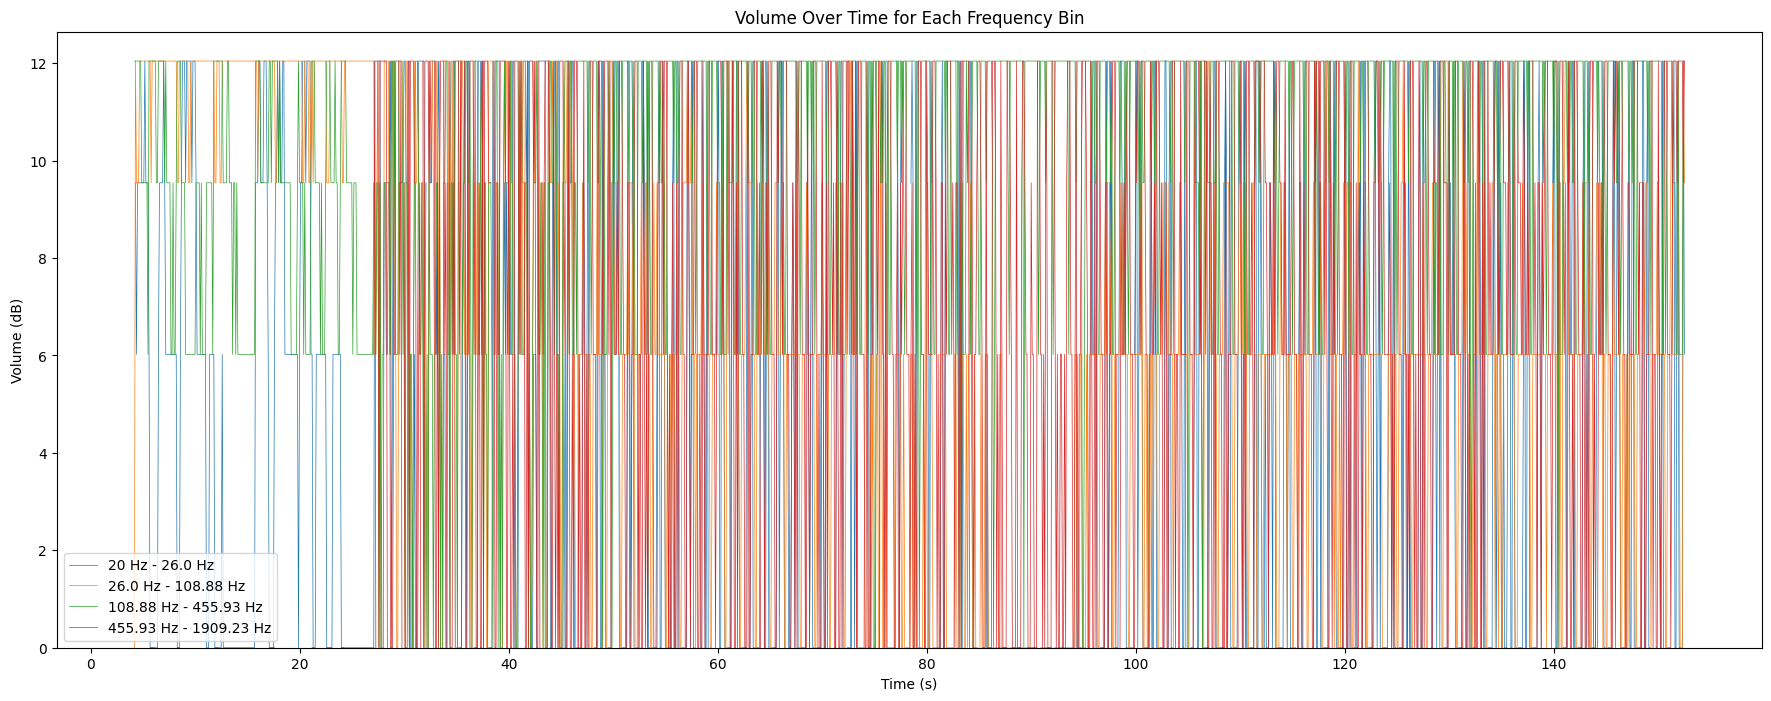

In [471]:
# Create a new figure
plt.figure(figsize=(22, 8))

# Generate lines for each frequency bin
for bin_index in range(num_bins):
    plt.plot(times, [20 * np.log10(vol_over_time[bin_index]) for vol_over_time in bin_vols_over_time], linewidth=0.5)

maxes = list(bin_edges)
maxes.append(9500)
mins = list(bin_edges)
mins.insert(0, 20)

# Add some labels
plt.xlabel('Time (s)')
plt.ylabel('Volume (dB)')
# Make the y label only display integer values
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.ylim(bottom=0)
plt.legend(['{} Hz - {} Hz'.format(round(mins[i],2), round(maxes[i],2)) for i in range(num_bins)])
plt.title('Volume Over Time for Each Frequency Bin')

# Display the plot
plt.show()


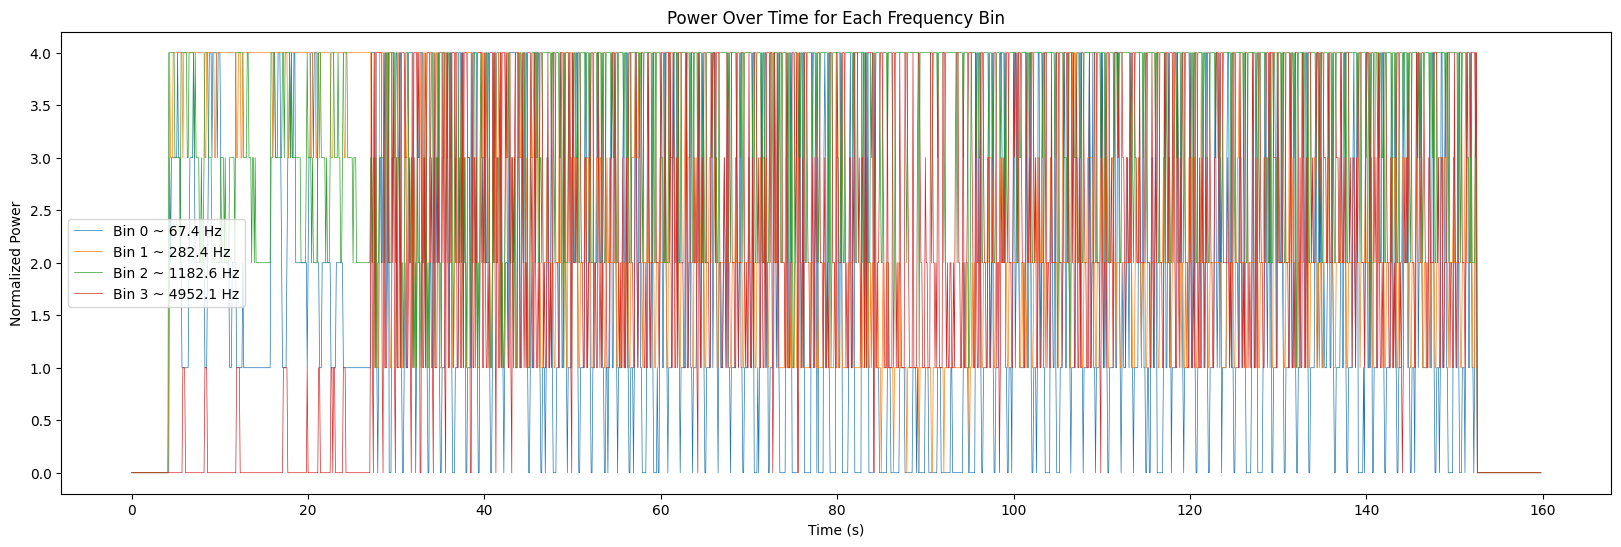

In [472]:
# For each bin, we want to plot a line
plt.figure(figsize=(20, 6))

for i in range(num_bins):
    # Get the power values of the current bin over time
    power_values = [vols[i] for vols in bin_vols_over_time]
    # Plot a line for the current bin
    plt.plot(times, power_values, label=f'Bin {i} ~ {bin_medians[i]:.1f} Hz', linewidth=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Normalized Power')
plt.title('Power Over Time for Each Frequency Bin')
plt.legend()
plt.show()

In [473]:
bin_medians

[67.438309745351, 282.40212266310346, 1182.5764789445102, 4952.112666026756]

In [486]:
import pygame
import serial
import time

print(serial.__file__)

# Create a serial object
ser = serial.Serial('/dev/cu.usbmodem24101', 9600)

# Initialize the mixer module
pygame.mixer.init()

# Load the music file
pygame.mixer.music.load(music)

# Wait for connection to establish
time.sleep(5)

# Start playing the music
pygame.mixer.music.play()

# Assuming your data is stored in bin_vols_over_time
for t in range(bin_vols_over_time.shape[0]):
    data = bin_vols_over_time[t]
    data_string = ",".join(map(str, data)) + "\n"
    ser.write(data_string.encode())

    # Wait for a tenth of a second before sending the next data
    time.sleep(0.1)

# Close the serial connection
ser.close()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/serial/__init__.py


KeyboardInterrupt: 

In [487]:
pygame.mixer.music.stop()
ser.close()



In [485]:
# sum of all columns
bin_vols_over_time[1340]

array([1, 1, 2, 4])